# Experiment 2

Extracting Features using pretrained convolutional base (MobileNet) then defining and training the densely connected classifier.

In [ ]:
# Base libraries
import numpy as np
import pandas as pd
import os, glob, shutil, math

# set up notebook to display multiple output in one cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Machine Learning libraries - SKLearn
from sklearn.datasets import fetch_openml
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier


# Machine Learning libraries - TensorFlow
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input


# Visualization libraries 
import seaborn as sns
%matplotlib inline
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.image import imread
import plotly.express as px

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}

pylab.rcParams.update(params)

# Image libraries
from PIL import Image

# Time libraries
from datetime import datetime
import time

# h5py file 
import h5py

# Progress bar
from tqdm import tqdm

print('Task Complete at {}'.format(datetime.now()))

Task Complete at 2021-05-21 02:38:32.161791


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

work_dir = "/content/gdrive/My Drive/MSDS_458_Deep_Learning/Assignment 4/"

Mounted at /content/gdrive


In [ ]:
imagewoof2_dir = work_dir + 'imagewoof2/'

In [ ]:
train_dir = os.path.join(imagewoof2_dir, 'train/')
val_dir = os.path.join(imagewoof2_dir, 'test/')

In [ ]:
NUM_CLASSES = 10
BATCH_SIZE = 64
IMG_WIDTH, IMG_HEIGHT = 224, 224

In [ ]:
train_images = [train_dir+i for i in os.listdir(train_dir)]
train_images

['/content/gdrive/My Drive/MSDS_458_Deep_Learning/Assignment 4/imagewoof2/train/australian_terrier',
 '/content/gdrive/My Drive/MSDS_458_Deep_Learning/Assignment 4/imagewoof2/train/golden_retriever',
 '/content/gdrive/My Drive/MSDS_458_Deep_Learning/Assignment 4/imagewoof2/train/english_foxhound',
 '/content/gdrive/My Drive/MSDS_458_Deep_Learning/Assignment 4/imagewoof2/train/shih-tzu',
 '/content/gdrive/My Drive/MSDS_458_Deep_Learning/Assignment 4/imagewoof2/train/rhodesian_ridgeback',
 '/content/gdrive/My Drive/MSDS_458_Deep_Learning/Assignment 4/imagewoof2/train/old_english_sheepdog',
 '/content/gdrive/My Drive/MSDS_458_Deep_Learning/Assignment 4/imagewoof2/train/border_terrier',
 '/content/gdrive/My Drive/MSDS_458_Deep_Learning/Assignment 4/imagewoof2/train/samoyed',
 '/content/gdrive/My Drive/MSDS_458_Deep_Learning/Assignment 4/imagewoof2/train/beagle',
 '/content/gdrive/My Drive/MSDS_458_Deep_Learning/Assignment 4/imagewoof2/train/pembroke-welsh-corgi']

In [ ]:
val_images = [val_dir+i for i in os.listdir(val_dir)]
val_images

['/content/gdrive/My Drive/MSDS_458_Deep_Learning/Assignment 4/imagewoof2/test/golden_retriever',
 '/content/gdrive/My Drive/MSDS_458_Deep_Learning/Assignment 4/imagewoof2/test/old_english_sheepdog',
 '/content/gdrive/My Drive/MSDS_458_Deep_Learning/Assignment 4/imagewoof2/test/australian_terrier',
 '/content/gdrive/My Drive/MSDS_458_Deep_Learning/Assignment 4/imagewoof2/test/samoyed',
 '/content/gdrive/My Drive/MSDS_458_Deep_Learning/Assignment 4/imagewoof2/test/shih-tzu',
 '/content/gdrive/My Drive/MSDS_458_Deep_Learning/Assignment 4/imagewoof2/test/beagle',
 '/content/gdrive/My Drive/MSDS_458_Deep_Learning/Assignment 4/imagewoof2/test/border_terrier',
 '/content/gdrive/My Drive/MSDS_458_Deep_Learning/Assignment 4/imagewoof2/test/rhodesian_ridgeback',
 '/content/gdrive/My Drive/MSDS_458_Deep_Learning/Assignment 4/imagewoof2/test/english_foxhound',
 '/content/gdrive/My Drive/MSDS_458_Deep_Learning/Assignment 4/imagewoof2/test/pembroke-welsh-corgi']

In [ ]:
# Define target dictionary
classes = {}
for i in range(len(train_images)):
    tmp = train_images[i].split('/content/gdrive/My Drive/MSDS_458_Deep_Learning/Assignment 4/imagewoof2/train/')[1]
    classes[tmp] = i
classes

{'australian_terrier': 0,
 'beagle': 8,
 'border_terrier': 6,
 'english_foxhound': 2,
 'golden_retriever': 1,
 'old_english_sheepdog': 5,
 'pembroke-welsh-corgi': 9,
 'rhodesian_ridgeback': 4,
 'samoyed': 7,
 'shih-tzu': 3}

In [ ]:
label_im = []
total_im = []
for k in range(len(train_images)):
  trainfd = train_images[k] + "/"
  label = trainfd.split('/content/gdrive/My Drive/MSDS_458_Deep_Learning/Assignment 4/imagewoof2/train/')[1].split("/")[0]
  label_im.append(label)
  train_images_tmp = [trainfd+i for i in os.listdir(trainfd)]
  df_images = train_images_tmp
  total_im.append(len(df_images))

In [ ]:
d = {'Labels': label_im,
     'Total': total_im}

dog_df = pd.DataFrame(d)
dog_df

,Labels,Total
0,australian_terrier,943
1,golden_retriever,949
2,english_foxhound,932
3,shih-tzu,941
4,rhodesian_ridgeback,942
5,old_english_sheepdog,928
6,border_terrier,949
7,samoyed,921
8,beagle,589
9,pembroke-welsh-corgi,164


In [ ]:
m = dog_df['Total'].sum()
m

8258

In [ ]:
X = np.ndarray((m, IMG_WIDTH, IMG_HEIGHT, 3), dtype=np.uint8)
y = np.zeros((m,1))

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

count = 0
for k in tqdm(range(len(train_images))):
    trainfd = train_images[k] + "/"
    label = trainfd.split('/content/gdrive/My Drive/MSDS_458_Deep_Learning/Assignment 4/imagewoof2/train/')[1].split("/")[0]
    label_num = classes[label]
    train_images_tmp = [trainfd+i for i in os.listdir(trainfd)]
    df_images = train_images_tmp
    #Find the total number of images
    m = len(df_images)
    #Create an array to put the data
    for i, image in enumerate(df_images):
        # Load the image
        im = load_img(image, target_size=(IMG_WIDTH, IMG_HEIGHT))
        # Convert to numpy array
        imArray = img_to_array(im)
        # Determine the labels for each image
        X[count,:] = imArray
        y[count,0] = label_num
        count += 1

100%|██████████| 10/10 [42:03<00:00, 252.34s/it]


In [ ]:
X.shape
y.shape

(8258, 224, 224, 3)

(8258, 1)

In [ ]:
label_im = []
total_im = []
for k in range(len(val_images)):
  trainfd = val_images[k] + "/"
  label = trainfd.split('/content/gdrive/My Drive/MSDS_458_Deep_Learning/Assignment 4/imagewoof2/test/')[1].split("/")[0]
  label_im.append(label)
  train_images_tmp = [trainfd+i for i in os.listdir(trainfd)]
  df_images = train_images_tmp
  total_im.append(len(df_images))

In [ ]:
d = {'Labels': label_im,
     'Total': total_im}

dog_df = pd.DataFrame(d)
dog_df

,Labels,Total
0,golden_retriever,401
1,old_english_sheepdog,422
2,australian_terrier,407
3,samoyed,429
4,shih-tzu,409
5,beagle,224
6,border_terrier,401
7,rhodesian_ridgeback,408
8,english_foxhound,418
9,pembroke-welsh-corgi,41


In [ ]:
m = dog_df['Total'].sum()
m

3560

In [ ]:
X_val = np.ndarray((m, IMG_WIDTH, IMG_HEIGHT, 3), dtype=np.uint8)
y_val = np.zeros((m,1))

In [ ]:
count = 0
for k in tqdm(range(len(val_images))):
    trainfd = val_images[k] + "/"
    label = trainfd.split('/content/gdrive/My Drive/MSDS_458_Deep_Learning/Assignment 4/imagewoof2/test/')[1].split("/")[0]
    label_num = classes[label]
    train_images_tmp = [trainfd+i for i in os.listdir(trainfd)]
    df_images = train_images_tmp
    #Find the total number of images
    m = len(df_images)
    #Create an array to put the data
    for i, image in enumerate(df_images):
        # Load the image
        im = load_img(image, target_size=(IMG_WIDTH, IMG_HEIGHT))
        # Convert to numpy array
        imArray = img_to_array(im)
        # Determine the labels for each image
        X_val[count,:] = imArray
        y_val[count,0] = label_num
        count += 1

100%|██████████| 10/10 [19:57<00:00, 119.80s/it]


In [ ]:
X_val.shape
y_val.shape

(3560, 224, 224, 3)

(3560, 1)

In [ ]:
x_train_norm = X.astype('float32') / 255

In [ ]:
x_val_norm = X_val.astype('float32') / 255

In [ ]:
Y_train = np.array(y).astype(int)

In [ ]:
Y_val = np.array(y_val).astype(int)

In [ ]:
target_train = Y_train.flatten()
target_val = Y_val.flatten()

In [ ]:
y_train_encoded = to_categorical(Y_train)

In [ ]:
y_val_encoded = to_categorical(Y_val)

In [ ]:
def predict_classes(x):
    y_pred_lst = []

    for i in range(len(x)):
        y_pred = x[i]
        y_pred = y_pred.flatten()
        max_target = np.max(y_pred)

        for j in range(len(y_pred)):
            if y_pred[j]==np.max(y_pred):
                y_pred_lst.append(j)
    return y_pred_lst

In [ ]:
def model_maker():
  base_model = MobileNet(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
  for layer in base_model.layers[:]:
    layer.trainable = False
  input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
  custom_model = base_model(input)
  custom_model = GlobalAveragePooling2D()(custom_model)
  custom_model = Dense(64, activation='relu')(custom_model)
  custom_model = Dropout(0.5)(custom_model)
  predictions = Dense(NUM_CLASSES, activation='softmax')(custom_model)
  return Model(inputs=input, outputs=predictions)

In [ ]:
model = model_maker()

17227776/17225924 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                65600     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 3,295,114
Trainable params: 66,250
Non-trainable params: 3,228,864
______________________________________________

In [ ]:
# hyperparameters
ETA = 0.001
EPOCH = 500
opt = Adam(learning_rate=ETA)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

checkpoint_cb = EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
# Record the start time
start=datetime.now()

history = model.fit(x_train_norm,
                    y_train_encoded,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCH,
                    verbose=1,
                    validation_data=(x_val_norm, y_val_encoded),
                    callbacks=[checkpoint_cb],
                    workers=4)

# Record the end time
end=datetime.now()
print(end-start)

Epoch 1/500
130/130 [==============================] - 27s 75ms/step - loss: 1.4722 - accuracy: 0.5071 - val_loss: 0.2606 - val_accuracy: 0.9199
Epoch 2/500
130/130 [==============================] - 9s 69ms/step - loss: 0.4474 - accuracy: 0.8498 - val_loss: 0.2080 - val_accuracy: 0.9354
Epoch 3/500
130/130 [==============================] - 9s 68ms/step - loss: 0.3557 - accuracy: 0.8804 - val_loss: 0.1874 - val_accuracy: 0.9407
Epoch 4/500
130/130 [==============================] - 9s 68ms/step - loss: 0.2783 - accuracy: 0.9051 - val_loss: 0.1865 - val_accuracy: 0.9402
Epoch 5/500
130/130 [==============================] - 9s 69ms/step - loss: 0.3012 - accuracy: 0.9021 - val_loss: 0.1790 - val_accuracy: 0.9413
Epoch 6/500
130/130 [==============================] - 9s 68ms/step - loss: 0.2695 - accuracy: 0.9083 - val_loss: 0.1748 - val_accuracy: 0.9421
Epoch 7/500
130/130 [==============================] - 9s 69ms/step - loss: 0.2164 - accuracy: 0.9278 - val_loss: 0.1746 - val_accuracy

In [ ]:
# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
model.save(work_dir + "my_h5_model_exp2x2.h5")

In [ ]:
from tensorflow.keras.models import load_model
model = load_model(work_dir + "my_h5_model_exp2x2.h5")

In [ ]:
score = model.evaluate(x_train_norm, y_train_encoded, verbose=0)
print("Train loss:", round(score[0],3))
print("Train accuracy:", round(score[1],3))

Train loss: 0.04
Train accuracy: 0.989


In [ ]:
score = model.evaluate(x_val_norm, y_val_encoded, verbose=0)
print("Val loss:", round(score[0],3))
print("Val accuracy:", round(score[1],3))

Val loss: 0.166
Val accuracy: 0.945


In [ ]:
# Get the predicted classes:
pred_train = model.predict(x_train_norm)
pred_val = model.predict(x_val_norm)

In [ ]:
y_pred_train = predict_classes(pred_train)
y_pred_val = predict_classes(pred_val)

In [ ]:
dict = history.history

d = {'loss': dict['loss'],
     'acc': dict['accuracy'],
     'val_loss': dict['val_loss'],
     'val_acc': dict['val_accuracy']}

history_df = pd.DataFrame(d)

Text(0.5, 1.0, '')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Accuracy')

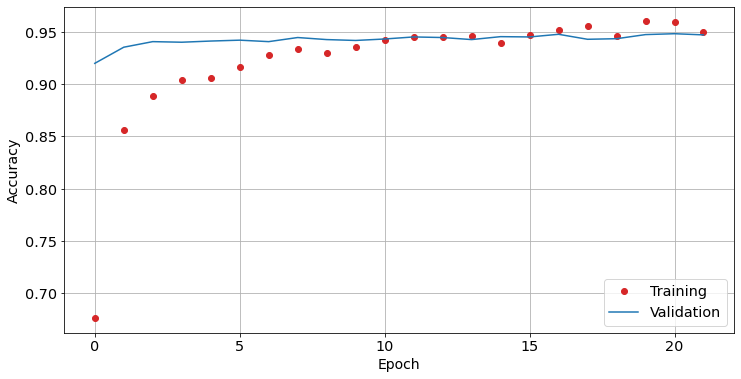

In [ ]:
#figure
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)

#labels
# Title
ax.set_title('', fontsize=16)
# x-axis
ax.set_xlabel('Epoch', fontsize=14)
# y-axis
color = 'tab:red'
ax.set_ylabel('Accuracy')

plt.plot(history_df['acc'], "o", color=color, label="Training")
 
color = 'tab:blue'
plt.plot(history_df['val_acc'], "-", color=color, label="Validation")


ax.grid(True)
plt.legend()
plt.show()

Text(0.5, 1.0, '')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Loss')

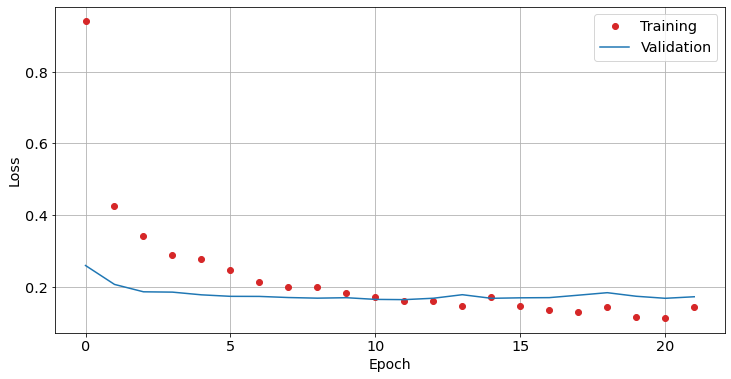

In [ ]:
#figure
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)

#labels
# Title
ax.set_title('', fontsize=16)
# x-axis
ax.set_xlabel('Epoch', fontsize=14)
# y-axis
color = 'tab:red'
ax.set_ylabel('Loss')

plt.plot(history_df['loss'], "o", color=color, label="Training")
 
color = 'tab:blue'
plt.plot(history_df['val_loss'], "-", color=color, label="Validation")


ax.grid(True)
plt.legend()
plt.show()

In [ ]:
cm = pd.DataFrame({'True': target_train,
                   'Predict': y_pred_train})
cm

,True,Predict
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
8253,9,9
8254,9,9
8255,9,9
8256,9,9


In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 10)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cf_matrix = confusion_matrix(cm['True'], cm['Predict'])
cf_matrix

array([[936,   1,   0,   3,   0,   2,   1,   0,   0,   0],
       [  2, 941,   0,   1,   1,   0,   1,   3,   0,   0],
       [  0,   0, 916,   1,   3,   0,   0,   0,  12,   0],
       [  2,   0,   0, 932,   1,   3,   1,   2,   0,   0],
       [  1,   0,   0,   0, 939,   0,   0,   0,   2,   0],
       [  4,   0,   0,   2,   0, 922,   0,   0,   0,   0],
       [  4,   0,   0,   0,   0,   2, 941,   0,   0,   2],
       [  0,   0,   0,   0,   0,   0,   0, 921,   0,   0],
       [  0,   0,  30,   0,   2,   0,   0,   0, 557,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0, 164]])

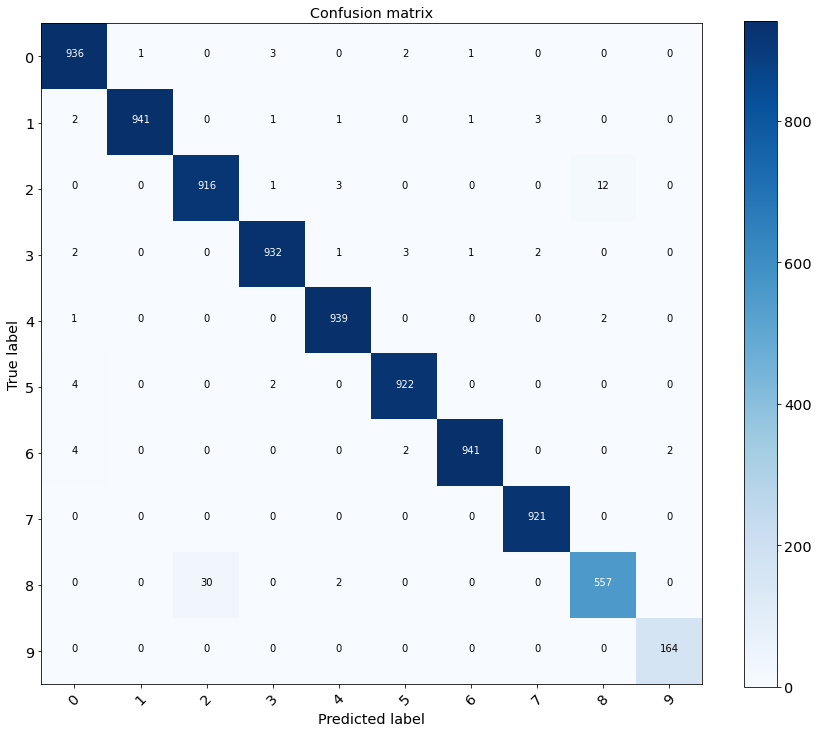

In [ ]:
# plot the confusion matrix
plot_confusion_matrix(cf_matrix, classes = range(10))

In [ ]:
cm_zero = (cf_matrix[0]/cf_matrix[0].sum()) * 100
cm_zero

array([99.25768823,  0.10604454,  0.        ,  0.31813362,  0.        ,
        0.21208908,  0.10604454,  0.        ,  0.        ,  0.        ])

In [ ]:
cm_rate = pd.DataFrame(cm_zero, columns = ['0'])

In [ ]:
for i in range(1,10):
    cm_tmp = (cf_matrix[i]/cf_matrix[i].sum()) * 100
    cm_rate[str(i)] = cm_tmp

In [ ]:
cm_rate = cm_rate.round(2)
cm_rate = cm_rate.T
cm_rate

,0,1,2,3,4,5,6,7,8,9
0,99.26,0.11,0.00,0.32,0.00,0.21,0.11,0.00,0.00,0.00
1,0.21,99.16,0.00,0.11,0.11,0.00,0.11,0.32,0.00,0.00
2,0.00,0.00,98.28,0.11,0.32,0.00,0.00,0.00,1.29,0.00
3,0.21,0.00,0.00,99.04,0.11,0.32,0.11,0.21,0.00,0.00
4,0.11,0.00,0.00,0.00,99.68,0.00,0.00,0.00,0.21,0.00
5,0.43,0.00,0.00,0.22,0.00,99.35,0.00,0.00,0.00,0.00
6,0.42,0.00,0.00,0.00,0.00,0.21,99.16,0.00,0.00,0.21
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00
8,0.00,0.00,5.09,0.00,0.34,0.00,0.00,0.00,94.57,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,100.00


In [ ]:
cm_rate.max(axis=0).sort_values(ascending=False)

9    100.00
7    100.00
4     99.68
5     99.35
0     99.26
6     99.16
1     99.16
3     99.04
2     98.28
8     94.57
dtype: float64

Text(0.5, 1.0, 'Error Rates')

Text(83.0, 0.5, 'True label')

Text(0.5, 65.0, 'Predicted label')

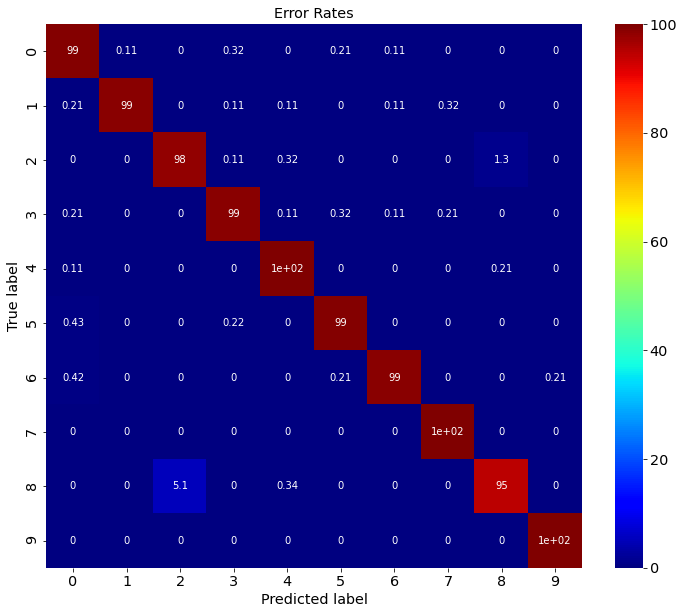

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
sns.heatmap(cm_rate, vmin=0, vmax=100, cmap="jet",annot=True)
plt.title('Error Rates')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
!pip install coremltools

     |████████████████████████████████| 3.4MB 8.1MB/s 
  Created wheel for attr: filename=attr-0.3.1-cp37-none-any.whl size=2458 sha256=f83bd567eefb043166871e3c30d475f265c4a04299a47ccb48c99e142a6d9d54
  Stored in directory: /root/.cache/pip/wheels/f0/96/9b/1f8892a707d17095b5a6eab0275da9d39e68e03a26aee2e726
Successfully built attr


In [ ]:
import coremltools as ct

In [ ]:
# Pass in `tf.keras.Model` to the Unified Conversion API
mlmodel = ct.convert(model)

Translating MIL ==> MLModel Ops: 100%|██████████| 410/410 [00:00<00:00, 970.28 ops/s] 


In [ ]:
mlmodel.save(work_dir + "exp2x2.mlmodel")